# Create all charts
---

## The data sets we used are:
* City of San Diego 311 service requests
* The San Diego zip codes from the US Census Bureau
* Economic census data for San Diego by zipcode from the US Census Bureau
* Open Weather Map History for temperature information

In [2]:
import os
import datetime
import numpy as np
import regex as reg
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format

font = {'size': 16}
pad = 16
plt.rc('font', **font)
plt.style.use('fivethirtyeight')

In [3]:
path_311 = os.path.join('..', 'data', '311_cleaned_data_.csv')
df = pd.read_csv(path_311)
df.dropna(inplace=True)
df.count()

service_request_id      29578
status_description      29578
mobile_web_status       29578
duplicate_verified      29578
override_duplicate      29578
functional_location     29578
source                  29578
closed_date             29578
updated_datetime        29578
open                    29578
closed                  29578
description             29578
agency_responsible      29578
service_name            29578
service_subtype         29578
lat                     29578
long                    29578
sap_problem_category    29578
sap_problem_type        29578
address                 29578
case_record_type        29578
district                29578
date                    29578
time                    29578
weekday                 29578
year                    29578
month                   29578
day                     29578
dtype: int64

In [4]:
final_path = os.path.join('..', 'data', 'final_311.csv')
final_df = pd.read_csv(final_path)
final_df.count()

zip_code                273337
Mean income             273337
MoE Mean income         273337
Median income           273337
MoE Median income       273337
total population        273337
service_request_id      273333
status_description      273333
mobile_web_status       273333
duplicate_verified      273333
override_duplicate      273333
functional_location     248264
source                  273332
closed_date             124629
updated_datetime        157712
open                    273333
closed                  273333
description             271997
agency_responsible      272778
service_name            272309
service_subtype          71812
lat                     273333
long                    273333
sap_problem_category    155658
sap_problem_type        155639
address                 272508
case_record_type        273333
district                272912
date                    273333
time                    273333
weekday                 273333
year                    273333
month   

### Number of 311 calls by month

* calls from 2017-03-11 to 2018-03-10

In [9]:
period_311 = df[df['date'] > '2017-03-10']
period_311 = period_311[period_311['date'] < '2018-03-11']
months = period_311.groupby('month', as_index=False)['service_request_id'].count()
months['month'] = months['month'].map(lambda x: datetime.date(1900, int(x), 1).strftime('%B'))

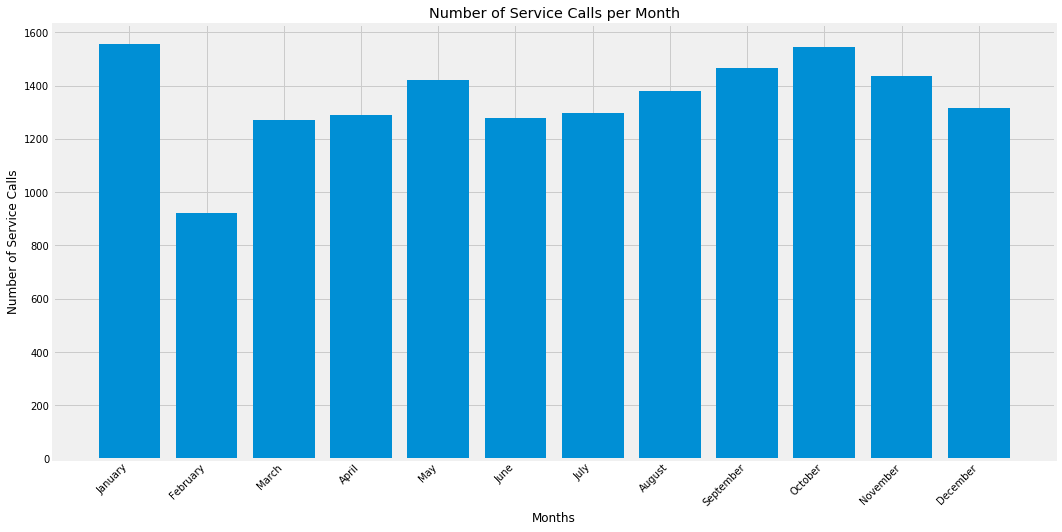

In [10]:
plt.figure(figsize=[16, 8])
plt.bar(months['month'], months['service_request_id'], align='center')
plt.title('Number of Service Calls per Month')
plt.xlabel('Months')
plt.ylabel('Number of Service Calls')
plt.xticks(rotation=45, ha='right')
plt.savefig(os.path.join('..', 'figures', 'calls_per_month_bar.png'))

### Number of Calls by Weekday

In [7]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', ]
weekdays = df.groupby('weekday', as_index=False)['service_request_id'].count()
weekdays['day_order'] = weekdays['weekday'].map(lambda x: days.index(x))
weekdays.sort_values('day_order', inplace=True)

NameError: name 'fontsize' is not defined

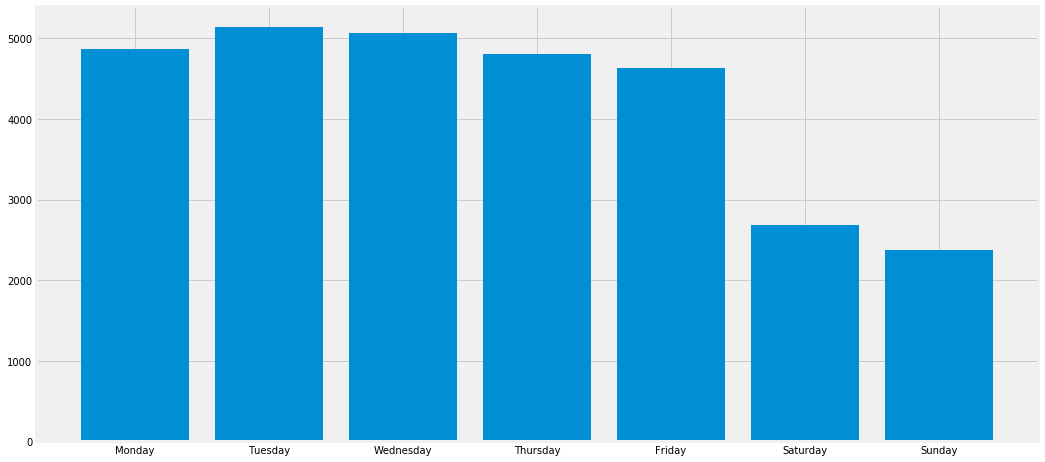

In [8]:
plt.figure(figsize=[16, 8])
plt.bar(weekdays['weekday'], weekdays['service_request_id'], align='center')
plt.title('Calls by Day of the Week', fontsize=fontsize, pad=fontsize)
plt.xlabel('Day of the Week', fontsize=fontsize, labelpad=fontsize)
plt.ylabel('Number of Calls', fontsize=fontsize, labelpad=fontsize)

### Number of Calls by Time of Day

## Number of 311 Call by Zip Code

In [ ]:
final_311_path = os.path.join('..','data','final_311.csv')
final_311_df = pd.read_csv(final_311_path)

In [ ]:
zip_service = final_311_df.groupby('zip_code')['service_request_id'].count().sort_values(ascending=False)
# zip_service

In [ ]:
fig, ax = plt.subplots(figsize=[16, 8])
zip_service_plt = zip_service.plot(kind='bar', color='green',alpha =0.75)
plt.xlabel('Zip Code', fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Number of Service Calls',fontsize=fontsize,labelpad=fontsize)
plt.title('Number of 311 Call by Zip Code',fontsize=fontsize,pad=fontsize)
plt.xticks(rotation=60, ha='right')
plt.savefig(os.path.join('..','figures','number_of_311_call_by_zip_code.png'))

### Number of 311 calls by type

* Garrett is working on this

In [ ]:
service = df.groupby('service_subtype')['service_request_id'].count().sort_values().tail(20)
fig, ax = plt.subplots(figsize=[16, 8])
service.plot.bar(zorder=2)
plt.xticks(rotation=70, ha='right')
plt.grid()

### breakdown of percentage of call categories

### locations of callers (bubble plot?)

### Number of calls per capita by zipcode

In [ ]:
pop_path = os.path.join('..', 'data', 'census_population_by_zip.csv')
pop_df = pd.read_csv(pop_path)
pop_df.tail()

### Number of calls by median household income of zip

In [ ]:
income_path = os.path.join('..', 'data', 'census_income_by_zip.csv')
income_df = pd.read_csv(income_path)
income_df.head()

In [ ]:
pop_income_df = pop_df.merge(income_df, on='zip_code', how='right')
pop_income_df.head()

In [ ]:
zip_gp = final_df.groupby('zip_code', as_index=False)
med_income = zip_gp['Median income'].mean()
zip_calls = zip_gp['service_request_id'].count()
total_pop = zip_gp['total population'].first()
total_pop.head()

In [ ]:
calls_income = med_income.merge(zip_calls, on='zip_code', how='outer')
calls_income = calls_income.merge(total_pop, on='zip_code', how='outer')
calls_income.head()

In [ ]:
bins = [0, 35000, 55000, 75000, 95000, 115000, 999999999]
bin_names = ['<$35,000', '\$35,001-\$55,000', '\$55,001-\$75,000', '\$75,001-\$95,000', '\$95,001-\$115,000', '>$115,000']
calls_income['income_ranges'] = pd.cut(x=calls_income['Median income'], bins=bins, labels=bin_names)
calls_income_gp = calls_income.groupby(by='income_ranges', as_index=False)
call_count = calls_income_gp['service_request_id'].sum()
total_pop_per_range = calls_income_gp['total population'].sum()
call_count['total population'] = total_pop_per_range['total population']
call_count['caller percentage'] = (call_count['service_request_id'] / call_count['total population']) * 100
call_count

In [ ]:

plt.figure(figsize=[16, 8])
plt.bar(call_count['income_ranges'], call_count['caller percentage'])
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of 311 Calls Per Capita')#, fontsize=fontsize, pad=fontsize)
plt.xlabel('Income')

In [ ]:
plt.scatter(med_income['Median income'], zip_calls['service_request_id'])

### Number of calls by crime rate of zip

### Percent of call types by median household income (stacked bar)

### Number of calls by Temperature scatter

* calls from 2017-03-11 to 2018-03-10

In [ ]:
owm_path = os.path.join('..', 'data', 'owm_2016_2018.csv')
temp_df = pd.read_csv(owm_path)
temp_df['date'] = temp_df['dt_iso'].map(lambda x: reg.sub('\s\d{2}:\d{2}:\d{2}\s\+\d{4}\sUTC', '', x))
temp_df = temp_df[temp_df['date'] > '2017-03-10']
temp_df = temp_df[temp_df['date'] < '2018-03-11']
temp_df = temp_df.groupby('date', as_index=False).mean()

In [ ]:
date_311 = period_311.groupby('date', as_index=False).count()

In [ ]:
plt.figure(figsize=[16, 8])
plt.scatter(date_311['service_request_id'], temp_df['temp_f'])
plt.title('Call Frequency by Temperature', pad=23)
plt.xlabel('Number of Calls', labelpad=16)
plt.ylabel('Temperature in Fahrenheit', labelpad=16)